In [58]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling

In [59]:
data = pd.read_csv('data_DL/dataset.csv')

In [60]:
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [61]:
print('Number of records:\t', data.shape[0])
print('Number of attributes:\t', data.shape[1])

Number of records:	 19906
Number of attributes:	 2


In [62]:
duplicates = data[data.duplicated()]
print('Number of duplicate rows:', duplicates.shape[0])

Number of duplicate rows: 0


In [63]:
missing = data[data.isnull().any(axis=1)]
print('Number of rows with missing value:', duplicates.shape[0])

Number of rows with missing value: 0


In [64]:
image_path = 'data_DL\\images'

missing_images = []

for img_name in data['ID']:
    img_file = os.path.join(image_path, img_name)
    if not os.path.exists(img_file):
        missing_images.append(img_name)

print('Number of missing images (jpg):', len(missing_images))

Number of missing images (jpg): 0


In [65]:
print(data['Class'].value_counts())

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


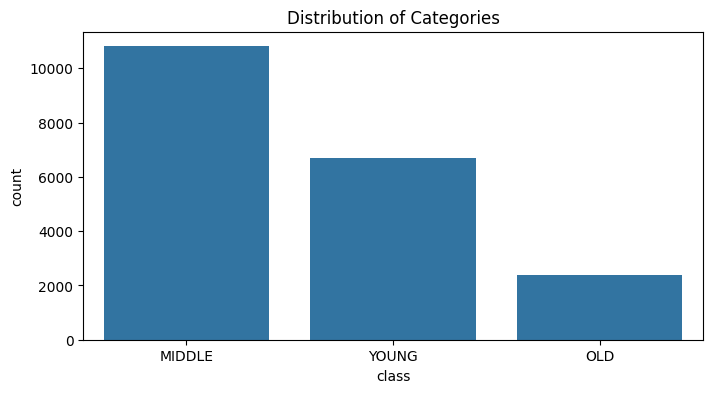

In [66]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Class', data=data)
plt.xlabel('class') 
plt.title('Distribution of Categories')
plt.show()

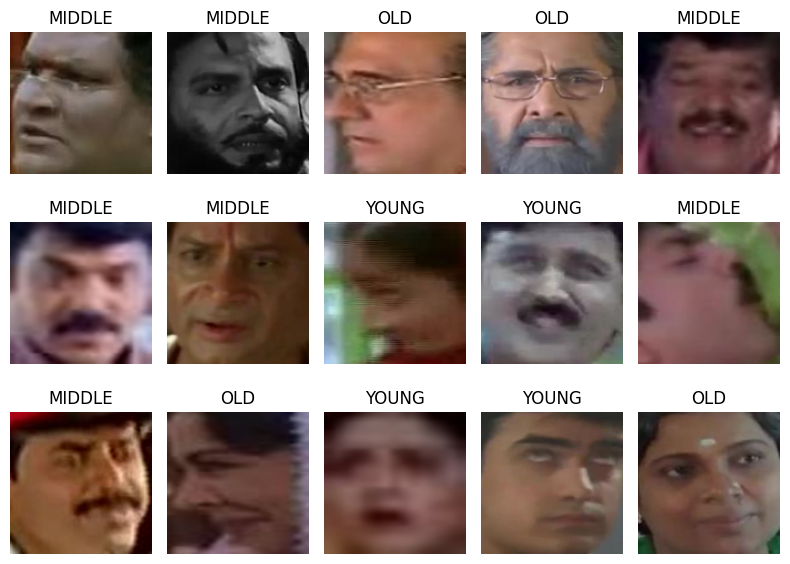

In [67]:
image_dir = 'data_DL\\images'
sample_data = data.sample(15)

fig, axes = plt.subplots(3, 5, figsize=(8, 6))
axes = axes.flatten()

for i, (index, row) in enumerate(sample_data.iterrows()):
    img_id = row['ID']
    category = row['Class']

    img_path = os.path.join(image_dir, img_id)
    img = Image.open(img_path)

    img = img.resize((128, 128))

    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [68]:
data['image_path'] = data['ID'].apply(lambda x: os.path.join(image_dir, x))

In [69]:
def image_to_numpy(img_path):
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    
    img_resized = tf.image.resize(img_array, (128, 128))
    
    return img_resized.numpy()

In [70]:
data['image_data'] = data['image_path'].apply(lambda x: image_to_numpy(x))
data.head()

,ID,Class,image_path,image_data
0,377.jpg,MIDDLE,data_DL\images\377.jpg,"[[[51.0, 47.0, 48.0], [51.0, 47.0, 48.0], [51...."
1,17814.jpg,YOUNG,data_DL\images\17814.jpg,"[[[47.0, 30.0, 36.0], [47.0, 30.0, 36.0], [47...."
2,21283.jpg,MIDDLE,data_DL\images\21283.jpg,"[[[43.98047, 39.98047, 38.98047], [43.98047, 3..."
3,16496.jpg,YOUNG,data_DL\images\16496.jpg,"[[[21.0, 21.0, 21.0], [21.0, 21.0, 21.0], [21...."
4,4487.jpg,MIDDLE,data_DL\images\4487.jpg,"[[[31.398438, 30.398438, 36.398438], [29.26171..."


In [71]:
data = pd.get_dummies(data, columns=['Class'], prefix='class')
data = data.drop(['ID', 'image_path'], axis=1)

data[['class_MIDDLE', 'class_OLD', 'class_YOUNG']] = data[['class_MIDDLE', 'class_OLD', 'class_YOUNG']].astype(int)

data.head()

,image_data,class_MIDDLE,class_OLD,class_YOUNG
0,"[[[51.0, 47.0, 48.0], [51.0, 47.0, 48.0], [51....",1,0,0
1,"[[[47.0, 30.0, 36.0], [47.0, 30.0, 36.0], [47....",0,0,1
2,"[[[43.98047, 39.98047, 38.98047], [43.98047, 3...",1,0,0
3,"[[[21.0, 21.0, 21.0], [21.0, 21.0, 21.0], [21....",0,0,1
4,"[[[31.398438, 30.398438, 36.398438], [29.26171...",1,0,0


In [72]:
X = np.stack(data['image_data'].to_numpy())
y = data[['class_YOUNG', 'class_MIDDLE', 'class_OLD']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [tf.convert_to_tensor(d, dtype=tf.float32) for d in [X_train, X_test, y_train, y_test]]
X_train, X_test, y_train, y_test = datasets

In [79]:
rescale_layer = Rescaling(scale=1.0/255)

X_train_transformed = rescale_layer(X_train)
X_test_transformed = rescale_layer(X_test)

In [84]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_transformed, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_transformed, y_test))

In [85]:
batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print('Train image batch shape:\t', images.shape)
    print('Train label batch shape:\t', labels.shape, '\n')

for images, labels in test_dataset.take(1):
    print('Test image batch shape: \t', images.shape)
    print('Test label batch shape: \t', labels.shape)

Train image batch shape:	 (32, 128, 128, 3)
Train label batch shape:	 (32, 3) 

Test image batch shape: 	 (32, 128, 128, 3)
Test label batch shape: 	 (32, 3)
